running average final: 3059.660094
min of all: 526.558018


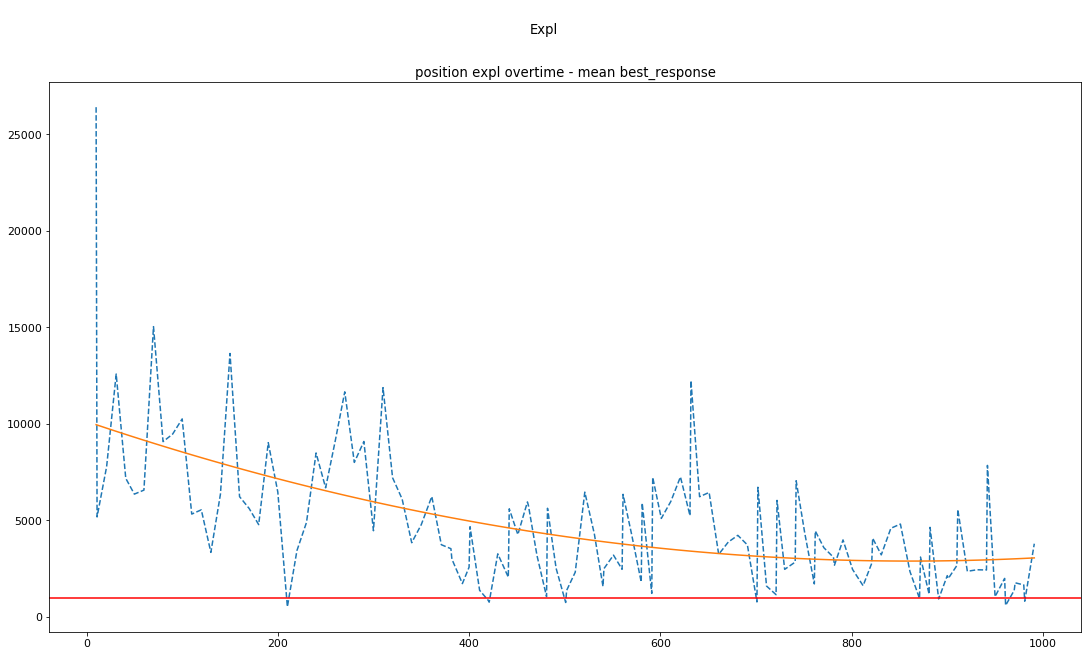

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import atan2,degrees

base = '../data/lab/dummy_test_100'
plt.rcParams.update({'font.size': 11})

#Label line with line2D label data
def labelLine(line,x,label=None,align=True,**kwargs):

    ax = line.axes
    xdata = line.get_xdata()
    ydata = line.get_ydata()

#     if (x < xdata[0]) or (x > xdata[-1]):
#         print('x label location is outside data range!')
#         return

    #Find corresponding y co-ordinate and angle of the line
    ip = 1
    for i in range(len(xdata)):
        if x < xdata[i]:
            ip = i
            break

    y = ydata[ip-1] + (ydata[ip]-ydata[ip-1])*(x-xdata[ip-1])/(xdata[ip]-xdata[ip-1])

    if not label:
        label = line.get_label()

    if align:
        #Compute the slope
        dx = xdata[ip] - xdata[ip-1]
        dy = ydata[ip] - ydata[ip-1]
        ang = degrees(atan2(dy,dx))

        #Transform to screen co-ordinates
        pt = np.array([x,y]).reshape((1,2))
        trans_angle = ax.transData.transform_angles(np.array((ang,)),pt)[0]

    else:
        trans_angle = 0

    #Set a bunch of keyword arguments
    if 'color' not in kwargs:
        kwargs['color'] = line.get_color()

    if ('horizontalalignment' not in kwargs) and ('ha' not in kwargs):
        kwargs['ha'] = 'center'

    if ('verticalalignment' not in kwargs) and ('va' not in kwargs):
        kwargs['va'] = 'center'

    if 'backgroundcolor' not in kwargs:
        kwargs['backgroundcolor'] = ax.get_facecolor()

    if 'clip_on' not in kwargs:
        kwargs['clip_on'] = True

    if 'zorder' not in kwargs:
        kwargs['zorder'] = 2.5

    ax.text(x,y,label,rotation=trans_angle,**kwargs)

def labelLines(lines,align=True,xvals=None,**kwargs):

    ax = lines[0].axes
    labLines = []
    labels = []

    #Take only the lines which have labels other than the default ones
    for line in lines:
        label = line.get_label()
        if "_line" not in label:
            labLines.append(line)
            labels.append(label)

    if xvals is None:
        xmin,xmax = ax.get_xlim()
        xvals = np.linspace(xmin,xmax,len(labLines)+2)[1:-1]

    for line,x,label in zip(labLines,xvals,labels):
        labelLine(line,x,label,align,**kwargs)
        
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(15, 9))
fig.suptitle("\nExpl\n")

df_expl = pd.read_csv(base+".expl")
#Exploitability - Weighted Response / Best Response
df = df_expl[df_expl["best_response"]==1]
for i in df.iter.unique():
    mean_value = df[df.iter==i].expl.mean()
    df = df.append({'iter': i, 'position':-1, 'expl':mean_value, 'best_response':1}, ignore_index=True)

plot_df = df[df['position']==-1]
x = plot_df['iter']
y = plot_df['expl']
z = np.polyfit(x, y, 2)
running_avg = z[0]*x*x + z[1]*x + z[2]

ax.title.set_text("position expl overtime - mean best_response")
ax.plot(x, y, label=("%s"%("br-mean")), linestyle='--')
ax.plot(x, running_avg)

ax.axhline(y=1000, color='r')

print("running average final: %f" % running_avg.iloc[-1])
print("min of all: %f" % y.min())

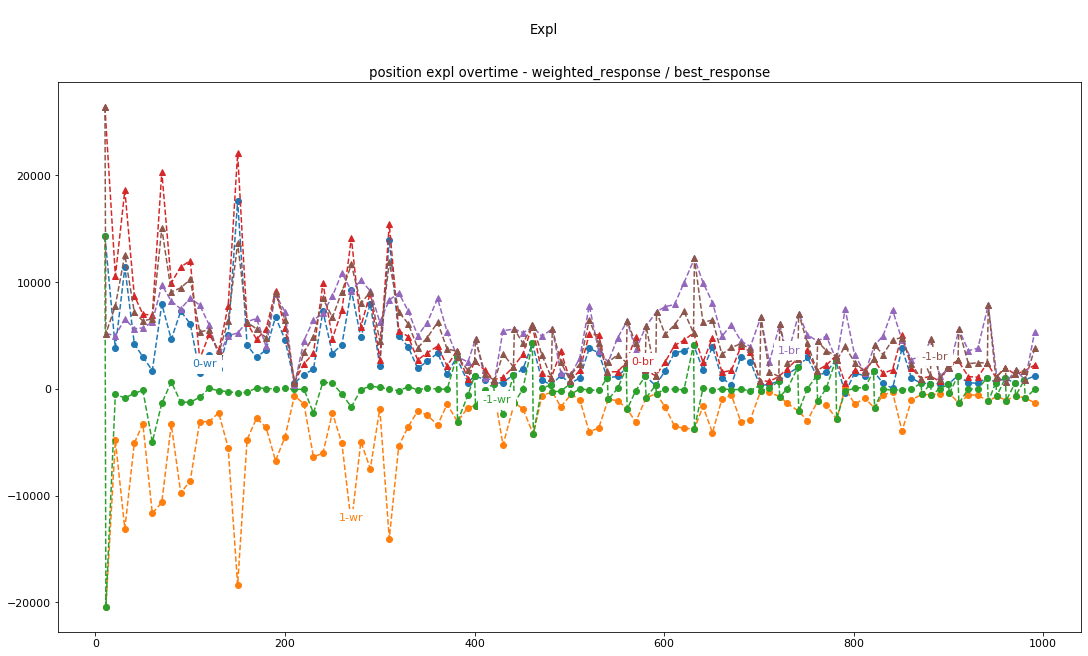

In [252]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(15, 9))
fig.suptitle("\nExpl\n")

df_expl = pd.read_csv(base+".expl")
#Exploitability - Weighted Response / Best Response
marker = ['o','^']
label_ext = ['wr', 'br']
for x, y in enumerate(['weighted_response', 'best_response']):
    df = df_expl[df_expl["best_response"]==x]
    for i in df.iter.unique():
        mean_value = df[df.iter==i].expl.mean()
        df = df.append({'iter': i, 'position':-1, 'expl':mean_value, 'best_response':x}, ignore_index=True)
    ax.title.set_text("position expl overtime - weighted_response / best_response")
    for i in df['position'].unique():
        plot_df = df[df['position']==i]
        ax.plot(plot_df['iter'], plot_df['expl'], label=("%d-%s"%(i, label_ext[x])), linestyle='--', marker=marker[x])
labelLines(ax.get_lines(), align=False)

ValueError: Wrong number of items passed 5, placement implies 1

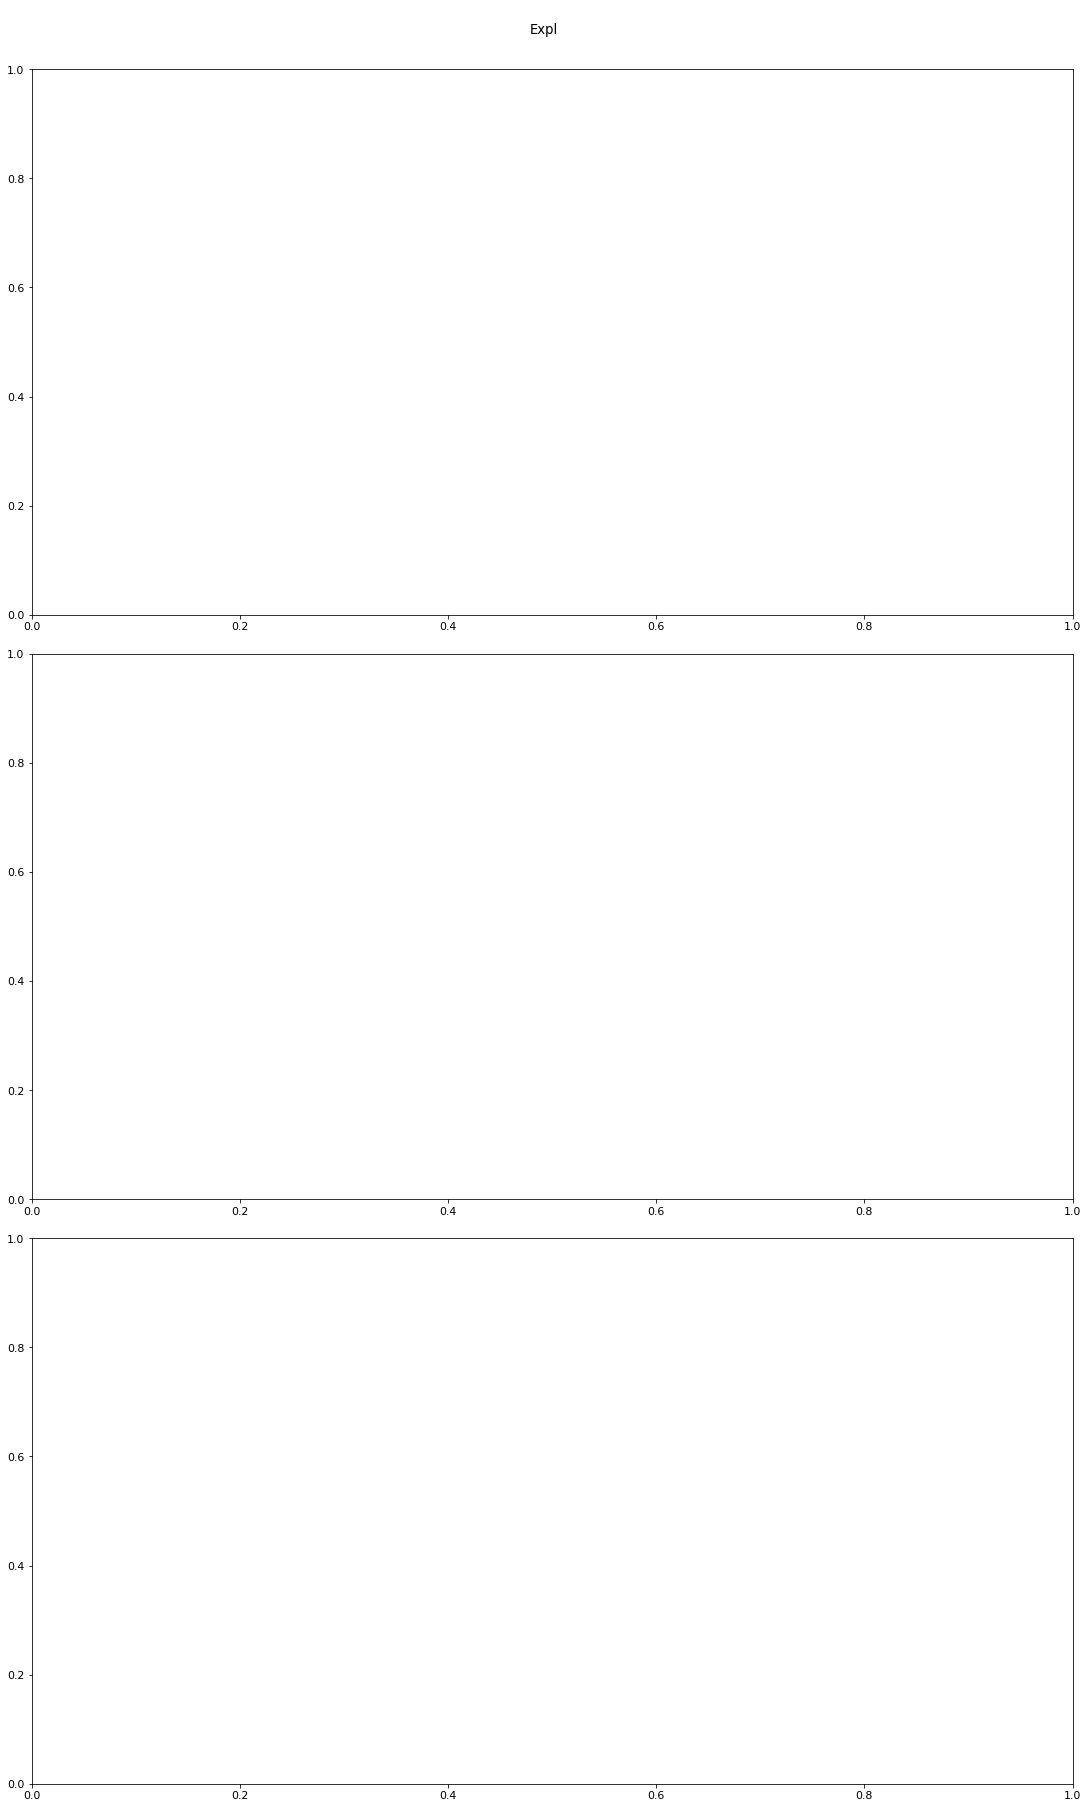

In [253]:
fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(15, 25))
fig.suptitle("\nExpl\n")

df_hexpl = pd.read_csv(base+".hexpl")
# #Handrank Exploitability - Weighted Response / Best Response
for x, y in enumerate(['weighted_response', 'best_response']):
    df = df_hexpl[df_hexpl["best_response"]==x]
    for i in df['iter'].unique():
        for j in df['rank'].unique():
            mean_value = df[(df['iter']==i) & (df['rank']==j)]['expl'].mean()
            df = df.append({'iter': i, 'rank':j, 'position':-1, 'expl':mean_value, 'best_response':x}, ignore_index=True)
    df['group'] = df.apply(lambda x: "%d_%d" %(x['rank'], x['position']), axis=1)
    df = df[~(df['position']==-1)]
    # df = df[(df['rank']>61)]
    ax = axs[x] #offset graph
    ax.title.set_text("handrank position winning overtime - %s"%y)
    for i in df['group'].unique():
        df_plot = df[df['group']==i]
        ax.plot(df_plot['iter'], df_plot['expl'], label=i, linestyle='--', marker='o')
    labelLines(ax.get_lines(), align=False)

#Hand Belief
df_hbs = pd.read_csv(base+".sb", index_col=0)
ax = axs[2]
ax.title.set_text("handrank belief and count")
ax.set_xlabel("iteration")
ax.set_ylabel("accumulated belief")
ax.plot(df_hbs.index, df_hbs['sum_belief'], color="red")
ax2 = ax.twinx()
ax2.set_ylabel("accumulated rank count")
ax2.bar(df_hbs.index, df_hbs['rank_position'], alpha=0.3)

In [ ]:
#Terminal Node
df_term = pd.read_csv(base+".term")
df_term['group'] = df_term.apply(lambda x: "%d_%d_%d" %(x['round'],x['node_id'], x['position']), axis=1)
# print(df_term.head())
df_term = df_term[df_term.group.str.contains('3_1')] 
df_term = df_term[df_term.group.str.endswith('_1')] 
#                   ~df_term.group.str.contains('3_7_') & 
#                   ~df_term.group.str.contains('3_3_')]
fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(40, 50))
fig.suptitle("\nTerminal Node Evaluation\n", fontsize=40)
for i, j in enumerate(['term_node_value','opp_hand_expl']):
    ax = axs[i]
    ax.title.set_text('\n'+j+'\n')
    ax.title.set_size(40)
    ax.set_xlabel('iteration', fontsize=35)
    ax.set_ylabel(j, fontsize=35)
    ax.tick_params(labelsize=50)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    for i in df_term['group'].unique():
        df = df_term[(df_term['group']==i)]
        ax.plot(df['iter'], df[j], label=i, linestyle='--', marker='o')
    labelLines(ax.get_lines(), align=False, fontsize=20)

In [ ]:
#Choice Node
df_choice = pd.read_csv(base+".choice")
df_choice['group'] = df_choice.apply(lambda x: "%d_%d_%d-%d-%d" %(x['round'],x['node_id'],x['action'],x['acting_player'], x['position']), axis=1)
# df_choice = df_choice[df_choice.group.str.startswith('3_0_')]
# df_choice = df_choice[df_choice.group.str.endswith('0')]
# print(df_choice.head())
fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(40, 55))
fig.suptitle("\nChoice Node Evaluation\n", fontsize=40)
for i, j in enumerate(['in_hand_expl','in_bucket_value','out_bucket_value']):
    ax = axs[i]
    ax.title.set_text('\n'+j+'\n')
    ax.title.set_size(30)
    ax.set_xlabel('iteration', fontsize=25)
    ax.set_ylabel(j, fontsize=25)
    ax.tick_params(labelsize=20)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    for i in df_choice['group'].unique():
        df = df_choice[(df_choice['group']==i)]
        p = ax.plot(df['iter'], df[j], label=i, linestyle='--', marker='o')
    labelLines(ax.get_lines(),align=False,fontsize=20)

In [ ]:
#Terminal Node terminal node value 
df_term = pd.read_csv(base+".term")
df_term['group'] = df_term.apply(lambda x: "%d_%d_%d" %(x['round'], x['node_id'], x['position']), axis=1)
# print(df_term.head())
df_term = df_term[df_term.group.str.endswith('_1')] 

actionDict = {
    '0':'f',
    '1':'c',
    '2':'r',
}
l = df_term['debug_code'].nunique()/2.0
l = int(np.ceil(l))
unique_sorted = (df_term['debug_code'].unique())
unique_sorted.sort()
# print(a)
# print(df_term['cause'].unique())
fig, axs = plt.subplots(l, 2, constrained_layout=True, figsize=(40,50))
fig.suptitle("\nTerminal Node value (0f 1c 2r) \n", fontsize=40)
for i, j in enumerate(unique_sorted):
#     print("%d,%d,%d,%d"%(i,j,int(i/2), i%2))
    ax = axs[int(i/2), i%2]
    idx = list("%s"%j)[0]
    actions = list(map(lambda x: actionDict[x], list("%s"%j)[1:]))
    ax.title.set_text("\n%s_%s\n"%(idx, '-'.join(actions)))
    ax.title.set_size(40)
    ax.set_xlabel('iteration', fontsize=35)
    ax.set_ylabel(j, fontsize=35)
    ax.tick_params(labelsize=50)
    df_cause = df_term[df_term['debug_code']==j]
    for k in df_cause['group'].unique():
        df = df_cause[(df_cause['group']==k)]
        ax.plot(df['iter'], df['term_node_value'], label=k, linestyle='--', marker='o')
    labelLines(ax.get_lines(), align=False, fontsize=40)

In [ ]:
#Terminal Node Reaching Cause 
df_term = pd.read_csv(base+".term")
df_term['group'] = df_term.apply(lambda x: "%d_%d_%d" %(x['round'], x['node_id'], x['position']), axis=1)
# print(df_term.head())
# df_term = df_term[df_term.group.str.endswith('_1')] 

actionDict = {
    '0':'f',
    '1':'c',
    '2':'r',
}
l = df_term['debug_code'].nunique()/2.0
l = int(np.ceil(l))
unique_sorted = (df_term['debug_code'].unique())
unique_sorted.sort()
# print(a)
# print(df_term['cause'].unique())
fig, axs = plt.subplots(l, 2, constrained_layout=True, figsize=(40,50))
fig.suptitle("\nTerminal Node P1 reach prob (0f 1c 2r) \n", fontsize=40)
for i, j in enumerate(unique_sorted):
#     print("%d,%d,%d,%d"%(i,j,int(i/2), i%2))
    ax = axs[int(i/2), i%2]
    idx = list("%s"%j)[0]
    actions = list(map(lambda x: actionDict[x], list("%s"%j)[1:]))
    ax.title.set_text("\n%s_%s\n"%(idx, '-'.join(actions)))
    ax.title.set_size(40)
    ax.set_xlabel('iteration', fontsize=35)
    ax.set_ylabel(j, fontsize=35)
    ax.tick_params(labelsize=50)
    df_cause = df_term[df_term['debug_code']==j]
    for k in df_cause['group'].unique():
        df = df_cause[(df_cause['group']==k)]
        ax.plot(df['iter'], df['p1_reach_prob_sum'], label=k, linestyle='--', marker='o')
    labelLines(ax.get_lines(), align=False, fontsize=40)

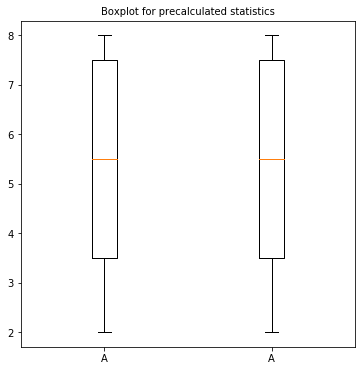

In [10]:
import matplotlib.pyplot as plt

stats = [{
    "label": 'A',  # not required
    "mean":  5,  # not required
    "med": 5.5,
    "q1": 3.5,
    "q3": 7.5,
    # "cilo": 5.3 # not required
    # "cihi": 5.7 # not required
    "whislo": 2.0,  # required
    "whishi": 8.0,  # required
    "fliers": []  # required if showfliers=True
    },{
    "label": 'A',  # not required
    "mean":  5,  # not required
    "med": 5.5,
    "q1": 3.5,
    "q3": 7.5,
    # "cilo": 5.3 # not required
    # "cihi": 5.7 # not required
    "whislo": 2.0,  # required
    "whishi": 8.0,  # required
    "fliers": []  # required if showfliers=True
    }]

fs = 10  # fontsize

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), sharey=True)
axes.bxp(stats)
axes.set_title('Boxplot for precalculated statistics', fontsize=fs)
plt.show()